# UiBench benchmark on Android

This benchmark is used to evaluate the responsiveness of an Android system to user interaction. Also **systraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
import logging

from conf import LisaLogging
LisaLogging.setup()

2017-03-06 12:36:21,955 INFO    : root         : Using LISA logging configuration:
2017-03-06 12:36:21,956 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload, System

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'UiBench')
        
    # Run UiBench
    wload.run(te.res_dir, test_name='TrivialAnimationActivity', duration_s=10, collect='systrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device
    "device"       : "FA6A10306347",
    
    # Android home
    "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",

    # Folder where all the results will be collected
    "results_dir" : "UiBench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-03-06 12:36:27,784 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2017-03-06 12:36:27,785 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-03-06 12:36:27,785 INFO    : TestEnv      : External tools using:
2017-03-06 12:36:27,785 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/android-sdk-linux/
2017-03-06 12:36:27,786 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools/catapult
2017-03-06 12:36:27,786 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2017-03-06 12:36:27,787 INFO    : TestEnv      : Connecting Android target [FA6A10306347]
2017-03-06 12:36:27,787 INFO    : TestEnv      : Connection settings:
2017-03-06 12:36:27,788 INFO    : TestEnv      :    {'device': 'FA6A10306347'}
2017-03-06 12:36:27,900 INFO    : android      : ls command is set to ls -1
2017-03-06 12:36:28,519 INFO    : TestEnv      : Initializing target workdir:
2017-03-06 12:36:28,519 INFO    : TestEnv      :    /da

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **UiBench - TrivialAnimation** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2017-03-06 12:36:33,270 INFO    : Workload     : Supported workloads available on target:
2017-03-06 12:36:33,271 INFO    : Workload     :   vellamo, youtube, jankbench, uibench, geekbench
2017-03-06 12:36:37,421 INFO    : Screen       : Set brightness: 0%
2017-03-06 12:36:38,223 INFO    : Screen       : Force manual orientation
2017-03-06 12:36:38,224 INFO    : Screen       : Set orientation: PORTRAIT
2017-03-06 12:36:40,404 INFO    : UiBench      : adb -s FA6A10306347 logcat ActivityManager:* System.out:I *:S BENCH:*
2017-03-06 12:36:41,089 WARNING : UiBench      : Systrace time NOT defined, tracing for 10[s]
2017-03-06 12:36:41,091 INFO    : UiBench      : Systrace START
2017-03-06 12:36:41,093 INFO    : System       : SysTrace: /home/vagrant/lisa/tools/catapult/systrace/systrace/run_systrace.py -e FA6A10306347 -o /home/vagrant/lisa/results/UiBench_example/trace.html gfx view sched freq idle -t 10
2017-03-06 12:36:41,104 INFO    : UiBench      : Benchmark [.TrivialAnimationActivity]

## Benchmarks results

In [7]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 58623815755246ns
Total frames rendered: 937
Janky frames: 10 (1.07%)
50th percentile: 8ms
90th percentile: 11ms
95th percentile: 12ms
99th percentile: 16ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [8]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.html')
trace = Trace(trace_file, my_conf['ftrace']['events'], platform)

trappy.plotter.plot_trace(trace.ftrace)

2017-03-06 12:38:57,076 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-03-06 12:38:57,092 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-03-06 12:38:57,289 INFO    : Analysis     : LITTLE cluster average frequency: 0.539 GHz
2017-03-06 12:38:57,289 INFO    : Analysis     : big    cluster average frequency: 0.650 GHz
2017-03-06 12:38:57,290 INFO    : root         : Plotting cluster frequencies for [sched]...


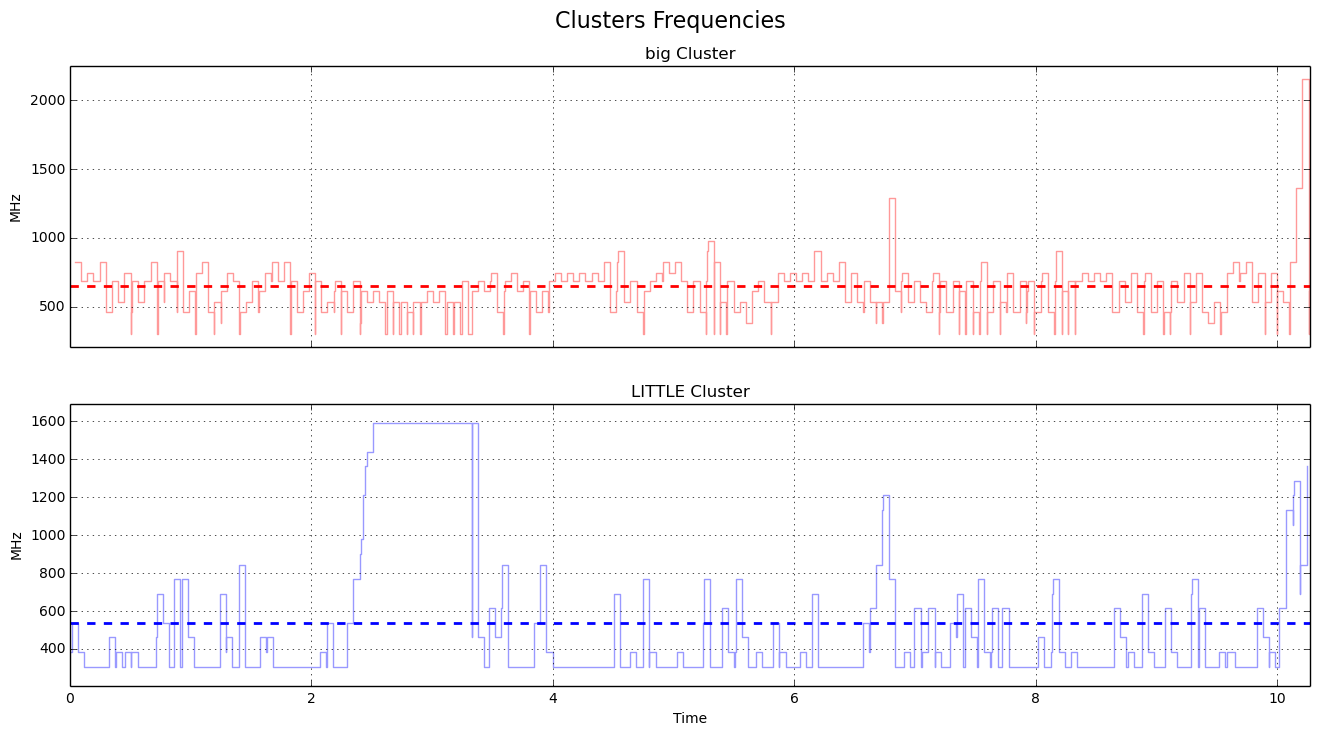

In [9]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass